# Imports

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import os
import cv2

from google.colab import drive
drive.mount("/content/drive")
root_dir = "/content/drive/Shareddrives/Project_4_Waldo/data"

Mounted at /content/drive


# Preparing data for model building

In [ ]:
imgs_waldo_64 = []
dir_waldo_64 = root_dir + "/Hey-Waldo/64/waldo/"
for img_name in os.listdir(dir_waldo_64):
    imgs_waldo_64.append([cv2.imread(dir_waldo_64 + img_name), 1])

In [ ]:
imgs_not_waldo_64 = []
dir_not_waldo_64 = root_dir + "/Hey-Waldo/64/notwaldo/"
for image in os.listdir(dir_not_waldo_64):
    imgs_not_waldo_64.append([cv2.imread(dir_not_waldo_64 + image), 0])

In [ ]:
# imgs_waldo_64[0][0]

In [ ]:
imgs_waldo_64[6][1]

1

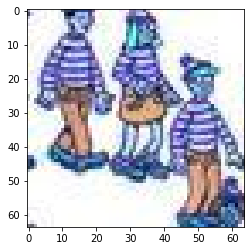

In [ ]:
plt.imshow(imgs_waldo_64[6][0])

# Creating train test set & balance

there are more images of not waldo than there are of waldo, so make both equal

In [ ]:
import random
random.shuffle(imgs_not_waldo_64)
random.shuffle(imgs_waldo_64)

In [ ]:
# imgs_not_waldo_64 = imgs_not_waldo_64[:len(imgs_waldo_64)]
imgs_not_waldo_64_bal = imgs_not_waldo_64[:len(imgs_waldo_64)]
len(imgs_not_waldo_64_bal)

39

In [ ]:
len(imgs_waldo_64)

39

There are so little picutres of waldo, so train will be 30, and test will be 9 pictures

In [ ]:
waldo_train = []
for x in range(0, 30):
    waldo_train.append(imgs_waldo_64[x])
    waldo_train.append(imgs_not_waldo_64_bal[x])
random.shuffle(waldo_train)

In [ ]:
waldo_test = []
for x in range(31, 39):
    waldo_test.append(imgs_waldo_64[x])
    waldo_test.append(imgs_not_waldo_64_bal[x])
random.shuffle(waldo_test)

Looking at our train test sets

In [ ]:
for sample in waldo_test:
    print(sample[1])

1
0
0
0
1
1
1
0
1
0
1
1
0
0
0
1


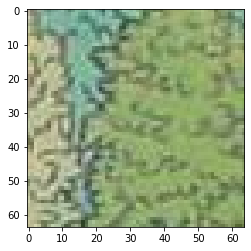

In [ ]:
plt.imshow(waldo_test[1][0])

In [ ]:
waldo_test[1][1]

0

Converting into X and y

In [ ]:
X_train, y_train = [], []
for features, label in waldo_train:
    X_train.append(features)
    y_train.append(label)
X_train = np.array(X_train).reshape(-1, 64, 64, 3)
y_train = np.array(y_train)

X_test, y_test = [], []
for features, label in waldo_test:
    X_test.append(features)
    y_test.append(label)
X_test = np.array(X_test).reshape(-1, 64, 64, 3)
y_test = np.array(y_test)

# Train & Test with no balance

In [ ]:
# X_train = []
# y_train = []
# for features, label in imgs_waldo_64:
#     X_train.append(features)
#     y_train.append(label)
# for features, label in imgs_not_waldo_64:
#     X_train.append(features)
#     y_train.append(label)
# random.shuffle(X_train)
# random.shuffle(y_train)
# X_train = np.array(X_train).reshape(-1, 64, 64, 3)
# y_train = np.array(y_train)

# Load / Save

Extra stuff for saving

In [ ]:
# import pickle
# def save_pickle(variable, name: str):
#     pickle_out = open(f"{name}.pickle", "wb")
#     pickle.dump(variable, pickle_out)
#     pickle_out.close()

In [ ]:
# save_pickle(X_train, "X_train")
# save_pickle(y_train, "y_train")
# save_pickle(X_test, "X_test")
# save_pickle(y_test, "y_test")

Extra stuff for loading

In [ ]:
# def load_pickle(name):
#     pickle_in = open(f"{name}.pickle", "rb")
#     return pickle.load(pickle_in)

In [ ]:
# X_train = load_pickle("X_train")
# y_train = load_pickle("y_train")
# X_test = load_pickle("X_test")
# y_test = load_pickle("y_test")

# Model building

Imports

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

Normalize data

In [ ]:
X_train = X_train / 255.0
X_test = X_test / 255.0

Creating custom loss function due to the unbalanced data

In [ ]:
import tensorflow.keras.backend as K

zero_weight = len(imgs_waldo_64) / (len(imgs_waldo_64) + len(imgs_not_waldo_64))
one_weight = len(imgs_not_waldo_64) / (len(imgs_waldo_64) + len(imgs_not_waldo_64))

In [ ]:
# def class_weighted_pixelwise_crossentropy(target, output):
#     output = tf.clip_by_value(output, 10e-8, 1.-10e-8)
#     weight = [len(imgs_waldo_64) / (len(imgs_waldo_64) + len(imgs_not_waldo_64)) , len(imgs_not_waldo_64) / (len(imgs_waldo_64) + len(imgs_not_waldo_64))]
#     return -tf.reduce_sum(target * weight * tf.log(output))

In [ ]:
def create_weighted_binary_crossentropy(zero_weight, one_weight):

    def weighted_binary_crossentropy(y_true, y_pred):

        # Original binary crossentropy (see losses.py):
        # K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

        # Calculate the binary crossentropy
        b_ce = K.binary_crossentropy(y_true, y_pred)

        # Apply the weights
        weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
        weighted_b_ce = weight_vector * b_ce

        # Return the mean error
        return K.mean(weighted_b_ce)

    return weighted_binary_crossentropy

Model Construction

In [ ]:
NUM_UNITS = 64
WINDOW_SHAPE = (3, 3)

model = Sequential()

# 2 x 64 convolutional neural network
model.add(Conv2D(NUM_UNITS, WINDOW_SHAPE, input_shape=X_train.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(NUM_UNITS, WINDOW_SHAPE))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten to 1D
model.add(Flatten())
model.add(Dense(64))

# output layer
model.add(Dense(1))
model.add(Activation("sigmoid"))

# compliling model
# create_weighted_binary_crossentropy(zero_weight, one_weight)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy", tf.keras.metrics.Recall()], loss_weights=[zero_weight, one_weight])  # "binary_crossentropy"

Model Fitting

In [ ]:
model.fit(X_train, y_train, batch_size=10, epochs=3, validation_split=.3)

Epoch 1/3
5/5 [==============================] - 2s 175ms/step - loss: 0.0135 - accuracy: 0.4524 - recall_1: 0.4211 - val_loss: 0.0075 - val_accuracy: 0.3889 - val_recall_1: 0.0000e+00
Epoch 2/3
5/5 [==============================] - 0s 94ms/step - loss: 0.0053 - accuracy: 0.5238 - recall_1: 0.5263 - val_loss: 0.0049 - val_accuracy: 0.6667 - val_recall_1: 0.6364
Epoch 3/3
5/5 [==============================] - 0s 98ms/step - loss: 0.0048 - accuracy: 0.6190 - recall_1: 0.2105 - val_loss: 0.0054 - val_accuracy: 0.3889 - val_recall_1: 0.0000e+00


# Analyzing Model Results

In [ ]:
preds = model.predict([X_test])
def view_pred(index: int = 0):
    #   print(np.argmax(preds[index]))
      print(f"Prediction Value: {preds[index]}")
      print(f"Prediction Rounded: {np.round(preds[index])}")
      figure, axis = plt.subplots(1, 2, figsize=(12, 8))
      axis[0].imshow(X_test[index], cmap=plt.cm.binary);
      axis[0].set_title("Input Image")
      axis[1].bar(range(0, 1), preds[index], color="red")
      axis[1].set_title("Prediction Confidence of Being Waldo")
      axis[1].set_yticks(np.arange(0, 1.0005, .1))
      axis[1].set_xticks([0])
    #   view_pred_confi(index)

In [ ]:
preds[0]

array([0.4175873], dtype=float32)

Prediction Value: [0.38480568]
Prediction Rounded: [0.]


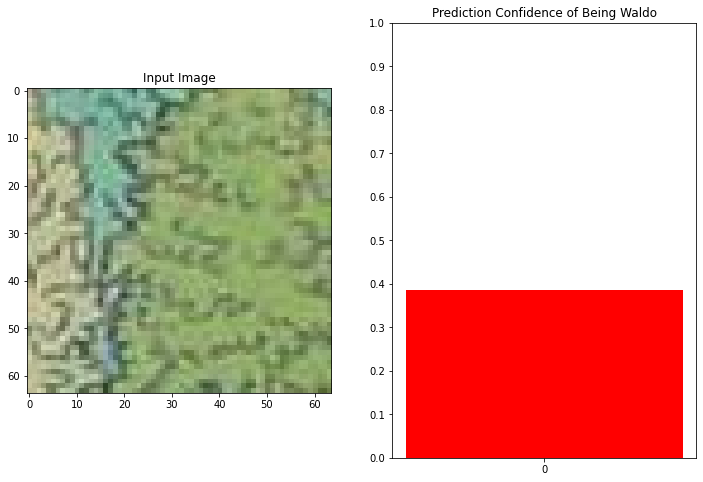

In [ ]:
view_pred(1)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 62, 62, 64)        1792      
                                                                 
 activation_3 (Activation)   (None, 62, 62, 64)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 activation_4 (Activation)   (None, 29, 29, 64)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                  